## Objective

Grad-CAM은 Class Activation Map의 일반화된 모델로, Global Average Pooling을 이용하지 않고 Gradient을 통해, Class Activation Map을 계산하는 방법론입니다. 별다른 학습 없이, 기존의 모델에 바로 적용할 수 있다는 점에서 매우 유용한 방법론입니다. 

그리고 적용 방법이 매우 간단하기 때문에, 여기서 살펴보도록 하겠습니다.


**reference**
* [paper : Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

### Grad-CAM :   Input에서 어떤 부분을 가지고 판단하였는가?

<img src="https://imgur.com/FC3Ab6E.png" width="500">

Grad-CAM은 위와 같이 특정 입력 이미지에서 어떤 부분을 보고 Label을 판단했는지를 결정하는 알고리즘입니다. Grad-CAM 'Cat'의 결과를 보면, 고양이라고 판단할 때 주요하게 반응했던 부분은 고양이의 다리와 몸통쪽임을 보실 수 있습니다. 그리고 강아지의 경우에는 강아지 얼굴을 보고 모형이 판단했음을 알 수 있습니다.

#### Grad-CAM 구조도

![Imgur](https://i.imgur.com/BqaK7V4.png)

Grad-CAM에서 가장 중요하게 여기는 정보는 바로 **마지막 Convolution Layer의 출력값**입니다. 영상 내 여러 특징 정보들이 CNN을 거치면서 Feature Map으로 변환됩니다. 마지막 Convolution Layer의 값에 따라 Image Classifacation / Image Captioning / Visual Question Answering 등 다양한 모델들이 그 결과를 추론할 수 있습니다. 마지막 Convolution Layer의 정보 중 어느 정보가 중요한지를 파악하는 게 핵심이고, 어느 정보가 중요한지를 파악하는 방법으로서 Grad-CAM에서는 기울기 정보를 확용합니다.

#### Grad-CAM의 핵심, Gradient



Class Activation Map의 경우, 우리는 각 필터의 중요도를 확인하기 위해 Global Average Pooling으로 필터 별로 요약하고, 거기에 Softmax를 통해 학습을 하였습니다. 대신 Grad-CAM에서는 Gradient에 주목하였습니다.

![Imgur](https://i.imgur.com/iuTUcoG.png)


국소적으로 보았을 때, 출력값은 이 기울기와 Feature Map의 선형결합으로 해석할 수 있습니다. CAM 방식에서 구한 Weight 대신 이 기울기로 Weight로 삼았습니다. 그래서 Gradient-Weighted CAM 방식을 일반화된 형태의 CAM 방식이라고 설명합니다.

### Grad-CAM 구현하기


#### - 모듈 가져오기

필요한 모듈은 아래와 같습니다.

In [61]:
%matplotlib inline
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### - 이미지 가져오기 

강아지와 레서판다 이미지가 있습니다. 이 두 이미지를 통해 어떤 식으로 GradCAM이 동작하는지를 파악해보도록 하겠습니다.

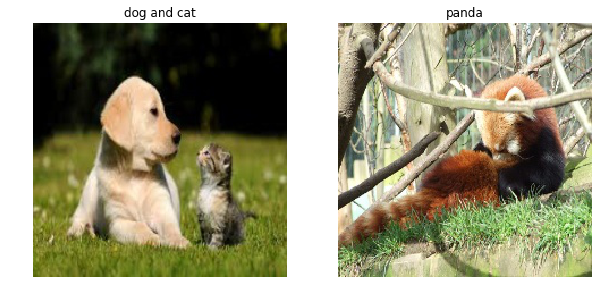

In [31]:
from tensorflow.keras.utils import get_file

ROOT_URL = "https://craftsangjae.s3.ap-northeast-2.amazonaws.com/images/"

dog_path = get_file("dog_and_cat.jpg", ROOT_URL+"dog_and_cat.jpg")
dog_image = plt.imread(dog_path)

panda_path = get_file("redpanda.jpg", ROOT_URL+"redpanda.jpg")
panda_image = plt.imread(panda_path)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("dog and cat")
ax[0].imshow(dog_image)
ax[0].axis('off')

ax[1].set_title("panda")
ax[1].imshow(panda_image)
ax[1].axis('off')
plt.show()

#### - VGG 모델 가져오기

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

vgg16 = VGG16()

for layer in vgg16.layers[::-1]:
    if 'conv' in layer.name:
        last_conv_layer = layer
        break

feature_map = last_conv_layer.output
class_output = vgg16.output

grad_model = Model(vgg16.input, [feature_map, class_output])

#### - Grad-CAM 메소드 구성하기

In [60]:
def get_gradcam_result(image):
    with tf.GradientTape() as tape:
        conv_outputs, model_outputs = grad_model(image[None])
        
        top_indices = tf.argmax(model_outputs, axis=1)
        top_logit = tf.gather(model_outputs, top_indices, axis=1)

    grads = tape.gradient(top_logit, conv_outputs)
    channel_importance = tf.reduce_mean(grads, axis=[1,2],
                                        keepdims=True)
    heat_map = tf.reduce_sum(channel_importance * conv_outputs, 
                             axis=-1, keepdims=True)
    heat_map = tf.nn.relu(heat_map)
    heat_map = tf.squeeze(heat_map)
    return model_outputs, tf.nn.relu(heat_map)

#### - heatmap 시각화 메소드 구현하기

In [50]:
def blend_heatmap(image, heatmap, ratio=0.5):
    image = np.array(image)
    heatmap = np.array(heatmap)
    h, w = image.shape[:2]
    heatmap = cv2.resize(heatmap, (w, h))
    
    heatmap = ((heatmap - heatmap.min())/
               (heatmap.max() - heatmap.min()))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    heatmap = heatmap / 255.
    
    norm_image = ((image - image.min())/
                  (image.max() - image.min()))
    blend_image = (heatmap * ratio 
                   + norm_image * (1-ratio))
    return blend_image

### 결과 시각화하기

#### 개와 고양이 사진

In [71]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

image = dog_image - [123.68,116.779,103.939,]
image = image.astype(np.float32)

prediction, heat_value = get_gradcam_result(image)
predicted_label = decode_predictions(prediction.numpy())[0][0][1]

blended_image = blend_heatmap(image, heat_value)

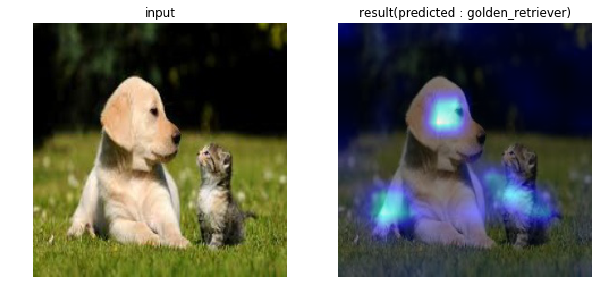

In [72]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("input")
ax[0].imshow(dog_image)
ax[0].axis('off')

ax[1].set_title(f"result(predicted : {predicted_label}")
ax[1].imshow(blended_image)
ax[1].axis('off')
plt.show()

#### 레서 판다 시각화하기

In [73]:
image = panda_image - [123.68,116.779,103.939,]
image = image.astype(np.float32)

prediction, heat_value = get_gradcam_result(image)
predicted_label = decode_predictions(prediction.numpy())[0][0][1]

blended_image = blend_heatmap(image, heat_value)

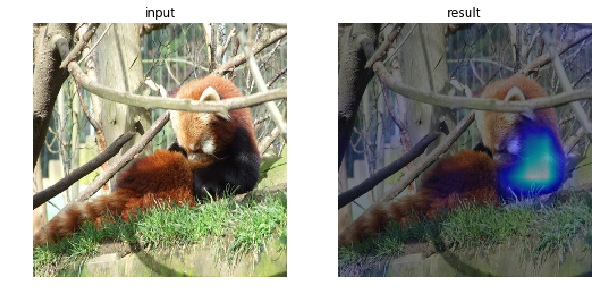

In [75]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("input")
ax[0].imshow(panda_image)
ax[0].axis('off')

ax[1].set_title("result")
ax[1].imshow(blended_image)
ax[1].axis('off')
plt.show()